<h1> Unzip data into colab session </h1>

In [0]:
#unzipping here in colab session
#!unzip '/content/drive/My Drive/MonuSeg.zip'

In [39]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [0]:
#%tensorflow_version 1.x

In [0]:
#keras version 2.2.3
#!pip uninstall keras
#!pip install keras==2.2.3

In [42]:
import tensorflow as tf
print(tf.__version__)

import keras
print(keras.__version__)

1.15.2
2.2.5


In [0]:
#Dataset MonuSeg
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

#import tensorflow as tf

#from keras.models import Model, load_model
#from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
#from keras.layers.core import Lambda, RepeatVector, Reshape
#from keras.layers.convolutional import Conv2D, Conv2DTranspose
#from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
#from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.optimizers import SGD

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

<h1> Load all the Data</h1>

In [0]:
# Set some parameters
im_width = 256
im_height = 256
depth = 3

In [45]:
# list of names all images in the given path
ids_train = next(os.walk("./Patch_MonuSeg/Training/TissueImages"))[2]
print("No. of images in training set= ", len(ids_train))

# list of names all images in the given path
ids_test = next(os.walk("./Patch_MonuSeg/Test/TissueImages"))[2]
print("No. of images in testing set = ", len(ids_test))

No. of images in training set=  1080
No. of images in testing set =  504


In [0]:
#train
X_train = np.zeros((len(ids_train), im_height, im_width, depth), dtype=np.float32)
y_train = np.zeros((len(ids_train), im_height, im_width, depth), dtype=np.float32)

#test
X_test = np.zeros((len(ids_test), im_height, im_width, depth), dtype=np.float32)
y_test = np.zeros((len(ids_test), im_height, im_width, depth), dtype=np.float32)

In [47]:
#train

# tqdm is used to display the progress bar
for n, id_ in tqdm_notebook(enumerate(ids_train), total=len(ids_train)):
    # Load images
    img = load_img("Patch_MonuSeg/Training/TissueImages/"+id_)
    x_img = img_to_array(img)
    x_img = resize(x_img, (im_width, im_height, depth), mode = 'constant', preserve_range = True)
    
    #rename mask
    d = id_.split('.')
    d1 = d[0].split('-')
    id_ = d1[0]+"-"+d1[1]+"-"+d1[2]+"-"+d1[3]+"-"+d1[4]+"-"+d1[5]+"_bin_mask-"+d1[-1]+"."+d[1]
    #print(id_)
    
    # Load masks
    mask = img_to_array(load_img("Patch_MonuSeg/Training/GroundTruth/"+id_))
    mask = resize(mask, (im_width, im_height, depth), mode = 'constant', preserve_range = True)
    # Save images
    X_train[n] = x_img/255.0
    y_train[n] = mask/255.0
    
    
    
#test

# tqdm is used to display the progress bar
for n, id_ in tqdm_notebook(enumerate(ids_test), total=len(ids_test)):
    # Load images
    img = load_img("Patch_MonuSeg/Test/TissueImages/"+id_)
    x_img = img_to_array(img)
    x_img = resize(x_img, (im_width, im_height, depth), mode = 'constant', preserve_range = True)
    
    #rename masks
    d = id_.split('.')
    d1 = d[0].split('-')
    id_ = d1[0]+"-"+d1[1]+"-"+d1[2]+"-"+d1[3]+"-"+d1[4]+"-"+d1[5]+"_bin_mask-"+d1[-1]+".png"
    #print(id_)
    #renamed becuase GT in filenames include _bin_mask in names
    
    # Load masks
    mask = img_to_array(load_img("Patch_MonuSeg/Test/GroundTruth/"+id_))
    mask = resize(mask, (im_width, im_height, depth), mode = 'constant', preserve_range = True)
    # Save images
    X_test[n] = x_img/255.0
    y_test[n] = mask/255.0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


<h1> Split for validation</h1>

In [48]:
X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test,
                                        test_size=0.3, random_state=42)

print(len(X_test))
print(len(X_valid))

352
152


<h1> Visualize training data</h1>

76
True


Text(0.5, 1.0, 'Mask')

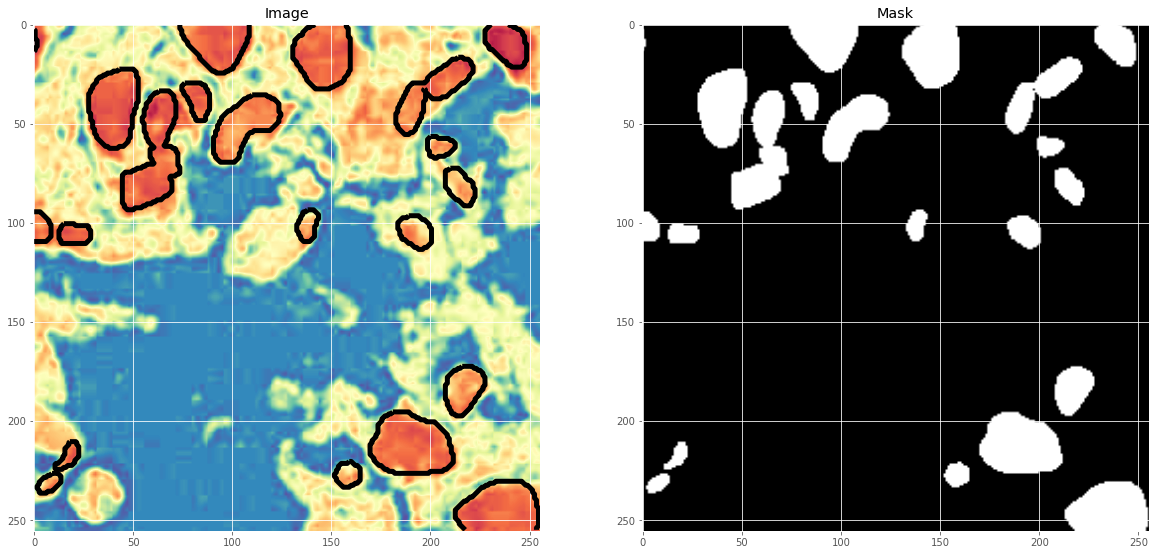

In [49]:
# Visualize any randome image along with the mask
ix = random.randint(0, len(X_train)-1)
print(ix)
has_mask = y_train[ix].max() > 0 # salt indicator
print(has_mask)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 15))

ax1.imshow(X_train[ix, ..., 0], cmap = 'Spectral', interpolation = 'bilinear')
if has_mask: # if salt
    # draw a boundary(contour) in the original image separating salt and non-salt areas
    ax1.contour(y_train[ix, ..., 0].squeeze(), colors = 'k', linewidths = 5, levels = [0.5])
ax1.set_title('Image')

ax2.imshow(y_train[ix, ..., 0].squeeze(), cmap = 'gray', interpolation = 'bilinear')
ax2.set_title('Mask')

<h1> Performance Metrices</h1>

In [0]:
#metrics
import keras.backend as K
def dice_coef(y_true, y_pred, smooth=1):
  
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    return (2. * intersection + smooth) / (K.sum(K.square(y_true),-1) + K.sum(K.square(y_pred),-1) + smooth)

def dice_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

def _recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def _precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_score(y_true, y_pred):
    precision = _precision(y_true, y_pred)
    recall = _recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

<h1> Define SegNet Model with indices pooling architecture </h1>

In [0]:
from keras import backend as K
from keras.layers import Layer


class MaxPoolingWithArgmax2D(Layer):

    def __init__(
            self,
            pool_size=(2, 2),
            strides=(2, 2),
            padding='same',
            **kwargs):
        super(MaxPoolingWithArgmax2D, self).__init__(**kwargs)
        self.padding = padding
        self.pool_size = pool_size
        self.strides = strides

    def call(self, inputs, **kwargs):
        padding = self.padding
        pool_size = self.pool_size
        strides = self.strides
        if K.backend() == 'tensorflow':
            ksize = [1, pool_size[0], pool_size[1], 1]
            padding = padding.upper()
            strides = [1, strides[0], strides[1], 1]
            output, argmax = tf.nn.max_pool_with_argmax(
                    inputs,
                    ksize=ksize,
                    strides=strides,
                    padding=padding)
        else:
            errmsg = '{} backend is not supported for layer {}'.format(
                    K.backend(), type(self).__name__)
            raise NotImplementedError(errmsg)
        argmax = K.cast(argmax, K.floatx())
        return [output, argmax]

    def compute_output_shape(self, input_shape):
        ratio = (1, 2, 2, 1)
        output_shape = [
                dim//ratio[idx]
                if dim is not None else None
                for idx, dim in enumerate(input_shape)]
        output_shape = tuple(output_shape)
        return [output_shape, output_shape]

    def compute_mask(self, inputs, mask=None):
        return 2 * [None]


class MaxUnpooling2D(Layer):
    def __init__(self, size=(2, 2), **kwargs):
        super(MaxUnpooling2D, self).__init__(**kwargs)
        self.size = size

    def call(self, inputs, output_shape=None):
        updates, mask = inputs[0], inputs[1]
        with tf.variable_scope(self.name):
            mask = K.cast(mask, 'int32')
            input_shape = tf.shape(updates, out_type='int32')
            #  calculation new shape
            if output_shape is None:
                output_shape = (
                        input_shape[0],
                        input_shape[1]*self.size[0],
                        input_shape[2]*self.size[1],
                        input_shape[3])
            self.output_shape1 = output_shape

            # calculation indices for batch, height, width and feature maps
            one_like_mask = K.ones_like(mask, dtype='int32')
            batch_shape = K.concatenate(
                    [[input_shape[0]], [1], [1], [1]],
                    axis=0)
            batch_range = K.reshape(
                    tf.range(output_shape[0], dtype='int32'),
                    shape=batch_shape)
            b = one_like_mask * batch_range
            y = mask // (output_shape[2] * output_shape[3])
            x = (mask // output_shape[3]) % output_shape[2]
            feature_range = tf.range(output_shape[3], dtype='int32')
            f = one_like_mask * feature_range

            # transpose indices & reshape update values to one dimension
            updates_size = tf.size(updates)
            indices = K.transpose(K.reshape(
                K.stack([b, y, x, f]),
                [4, updates_size]))
            values = K.reshape(updates, [updates_size])
            ret = tf.scatter_nd(indices, values, output_shape)
            return ret

    def compute_output_shape(self, input_shape):
        mask_shape = input_shape[1]
        return (
                mask_shape[0],
                mask_shape[1]*self.size[0],
                mask_shape[2]*self.size[1],
                mask_shape[3]
                )

In [0]:
from keras.models import Model
from keras.layers import Input
from keras.layers.core import Activation, Reshape
from keras.layers.convolutional import Convolution2D
from keras.layers.normalization import BatchNormalization

#from layers import MaxPoolingWithArgmax2D, MaxUnpooling2D


def segnet(
        input_shape,
        n_labels,
        kernel=3,
        pool_size=(2, 2),
        output_mode="softmax"):
    # encoder
    inputs = Input(shape=input_shape)

    conv_1 = Convolution2D(64, (kernel, kernel), padding="same")(inputs)
    conv_1 = BatchNormalization()(conv_1)
    conv_1 = Activation("relu")(conv_1)
    conv_2 = Convolution2D(64, (kernel, kernel), padding="same")(conv_1)
    conv_2 = BatchNormalization()(conv_2)
    conv_2 = Activation("relu")(conv_2)

    pool_1, mask_1 = MaxPoolingWithArgmax2D(pool_size)(conv_2)

    conv_3 = Convolution2D(128, (kernel, kernel), padding="same")(pool_1)
    conv_3 = BatchNormalization()(conv_3)
    conv_3 = Activation("relu")(conv_3)
    conv_4 = Convolution2D(128, (kernel, kernel), padding="same")(conv_3)
    conv_4 = BatchNormalization()(conv_4)
    conv_4 = Activation("relu")(conv_4)

    pool_2, mask_2 = MaxPoolingWithArgmax2D(pool_size)(conv_4)

    conv_5 = Convolution2D(256, (kernel, kernel), padding="same")(pool_2)
    conv_5 = BatchNormalization()(conv_5)
    conv_5 = Activation("relu")(conv_5)
    conv_6 = Convolution2D(256, (kernel, kernel), padding="same")(conv_5)
    conv_6 = BatchNormalization()(conv_6)
    conv_6 = Activation("relu")(conv_6)
    conv_7 = Convolution2D(256, (kernel, kernel), padding="same")(conv_6)
    conv_7 = BatchNormalization()(conv_7)
    conv_7 = Activation("relu")(conv_7)

    pool_3, mask_3 = MaxPoolingWithArgmax2D(pool_size)(conv_7)

    conv_8 = Convolution2D(512, (kernel, kernel), padding="same")(pool_3)
    conv_8 = BatchNormalization()(conv_8)
    conv_8 = Activation("relu")(conv_8)
    conv_9 = Convolution2D(512, (kernel, kernel), padding="same")(conv_8)
    conv_9 = BatchNormalization()(conv_9)
    conv_9 = Activation("relu")(conv_9)
    conv_10 = Convolution2D(512, (kernel, kernel), padding="same")(conv_9)
    conv_10 = BatchNormalization()(conv_10)
    conv_10 = Activation("relu")(conv_10)

    pool_4, mask_4 = MaxPoolingWithArgmax2D(pool_size)(conv_10)

    conv_11 = Convolution2D(512, (kernel, kernel), padding="same")(pool_4)
    conv_11 = BatchNormalization()(conv_11)
    conv_11 = Activation("relu")(conv_11)
    conv_12 = Convolution2D(512, (kernel, kernel), padding="same")(conv_11)
    conv_12 = BatchNormalization()(conv_12)
    conv_12 = Activation("relu")(conv_12)
    conv_13 = Convolution2D(512, (kernel, kernel), padding="same")(conv_12)
    conv_13 = BatchNormalization()(conv_13)
    conv_13 = Activation("relu")(conv_13)

    pool_5, mask_5 = MaxPoolingWithArgmax2D(pool_size)(conv_13)
    print("Build encoder done..")

    # decoder

    unpool_1 = MaxUnpooling2D(pool_size)([pool_5, mask_5])

    conv_14 = Convolution2D(512, (kernel, kernel), padding="same")(unpool_1)
    conv_14 = BatchNormalization()(conv_14)
    conv_14 = Activation("relu")(conv_14)
    conv_15 = Convolution2D(512, (kernel, kernel), padding="same")(conv_14)
    conv_15 = BatchNormalization()(conv_15)
    conv_15 = Activation("relu")(conv_15)
    conv_16 = Convolution2D(512, (kernel, kernel), padding="same")(conv_15)
    conv_16 = BatchNormalization()(conv_16)
    conv_16 = Activation("relu")(conv_16)

    unpool_2 = MaxUnpooling2D(pool_size)([conv_16, mask_4])

    conv_17 = Convolution2D(512, (kernel, kernel), padding="same")(unpool_2)
    conv_17 = BatchNormalization()(conv_17)
    conv_17 = Activation("relu")(conv_17)
    conv_18 = Convolution2D(512, (kernel, kernel), padding="same")(conv_17)
    conv_18 = BatchNormalization()(conv_18)
    conv_18 = Activation("relu")(conv_18)
    conv_19 = Convolution2D(256, (kernel, kernel), padding="same")(conv_18)
    conv_19 = BatchNormalization()(conv_19)
    conv_19 = Activation("relu")(conv_19)

    unpool_3 = MaxUnpooling2D(pool_size)([conv_19, mask_3])

    conv_20 = Convolution2D(256, (kernel, kernel), padding="same")(unpool_3)
    conv_20 = BatchNormalization()(conv_20)
    conv_20 = Activation("relu")(conv_20)
    conv_21 = Convolution2D(256, (kernel, kernel), padding="same")(conv_20)
    conv_21 = BatchNormalization()(conv_21)
    conv_21 = Activation("relu")(conv_21)
    conv_22 = Convolution2D(128, (kernel, kernel), padding="same")(conv_21)
    conv_22 = BatchNormalization()(conv_22)
    conv_22 = Activation("relu")(conv_22)

    unpool_4 = MaxUnpooling2D(pool_size)([conv_22, mask_2])

    conv_23 = Convolution2D(128, (kernel, kernel), padding="same")(unpool_4)
    conv_23 = BatchNormalization()(conv_23)
    conv_23 = Activation("relu")(conv_23)
    conv_24 = Convolution2D(64, (kernel, kernel), padding="same")(conv_23)
    conv_24 = BatchNormalization()(conv_24)
    conv_24 = Activation("relu")(conv_24)

    unpool_5 = MaxUnpooling2D(pool_size)([conv_24, mask_1])

    conv_25 = Convolution2D(64, (kernel, kernel), padding="same")(unpool_5)
    conv_25 = BatchNormalization()(conv_25)
    conv_25 = Activation("relu")(conv_25)

    #old
    #conv_26 = Convolution2D(n_labels, (1, 1), padding="valid")(conv_25)
    #conv_26 = BatchNormalization()(conv_26)
    #conv_26 = Reshape(
    #        (input_shape[0]*input_shape[1], n_labels),
    #        input_shape=(input_shape[0], input_shape[1], n_labels))(conv_26)

    #outputs = Activation(output_mode)(conv_25)
    print("Build decoder done..")

    #conv = Conv2D(1,(1, 1),strides=(1, 1), padding='same')(block10)
    #conv_reshape = Reshape((512*512,1))(conv)
    #outputs = Activation('softmax')(block10)
    outputs = Convolution2D(3, (1, 1),padding='same', activation='sigmoid')(conv_25)

    model = Model(inputs=inputs, outputs=outputs, name="SegNet")

    return model

<h1> Compile and Summarize Model</h1>

In [54]:
#input_img = Input((im_height, im_width, 1), name='img')
model = segnet(input_shape=(im_height, im_width, depth),n_labels=1)

#model.summary()
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

model.compile(loss='binary_crossentropy',optimizer=Adam(),metrics=['accuracy',dice_coef,f1_score]) 

Build encoder done..
Build decoder done..


In [0]:
from cyclical_learning_rate import *
callbacks = [
    #EarlyStopping(patience=20, verbose=1),
    #ReduceLROnPlateau(factor=0.001, patience=5, min_lr=0.00001, verbose=1),
    CyclicLR(base_lr=0.01, max_lr=0.00001, mode='triangular',
                   step_size= 8 * (X_train.shape[0] // 10)),
    ModelCheckpoint('model-monuseg-SegNet.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

<h1> Train the Model </h1>

In [58]:
results = model.fit(X_train, y_train, batch_size=4, epochs=8, callbacks=callbacks,
                    validation_data=(X_valid, y_valid))

Train on 1080 samples, validate on 152 samples
Epoch 1/16
1080/1080 [==============================] - 118s 109ms/step - loss: 0.4207 - acc: 0.8113 - dice_coef: 0.8547 - f1_score: 0.6030 - val_loss: 4.2373 - val_acc: 0.4425 - val_dice_coef: 0.5695 - val_f1_score: 0.3855

Epoch 00001: val_loss improved from inf to 4.23732, saving model to model-monuseg-SegNet.h5
Epoch 2/16
1080/1080 [==============================] - 115s 106ms/step - loss: 0.3941 - acc: 0.8269 - dice_coef: 0.8674 - f1_score: 0.6413 - val_loss: 0.8144 - val_acc: 0.8015 - val_dice_coef: 0.8553 - val_f1_score: 3.1285e-06

Epoch 00002: val_loss improved from 4.23732 to 0.81436, saving model to model-monuseg-SegNet.h5
Epoch 3/16
1080/1080 [==============================] - 115s 107ms/step - loss: 0.3765 - acc: 0.8362 - dice_coef: 0.8743 - f1_score: 0.6664 - val_loss: 0.4476 - val_acc: 0.8013 - val_dice_coef: 0.8463 - val_f1_score: 0.5504

Epoch 00003: val_loss improved from 0.81436 to 0.44758, saving model to model-monuseg-

<h1> Performance Graphs </h1>

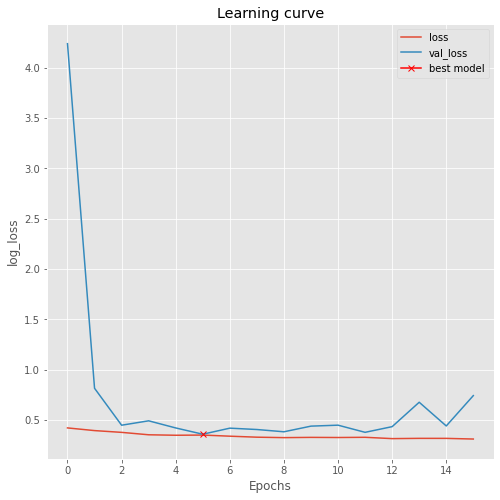

In [59]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

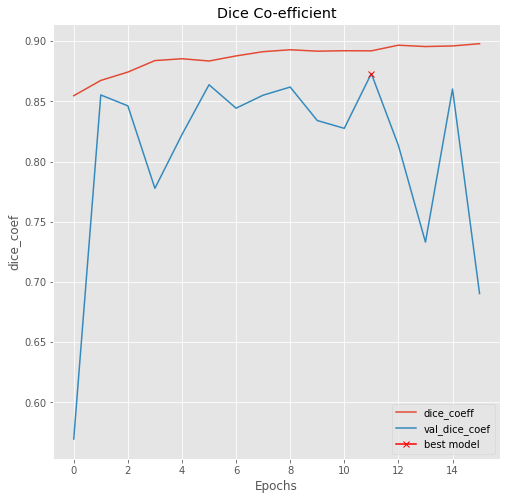

In [60]:
plt.figure(figsize=(8, 8))
plt.title("Dice Co-efficient")
plt.plot(results.history['dice_coef'], label="dice_coeff")
plt.plot(results.history["val_dice_coef"], label="val_dice_coef")
plt.plot( np.argmax(results.history["val_dice_coef"]), np.max(results.history["val_dice_coef"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("dice_coef")
plt.legend();

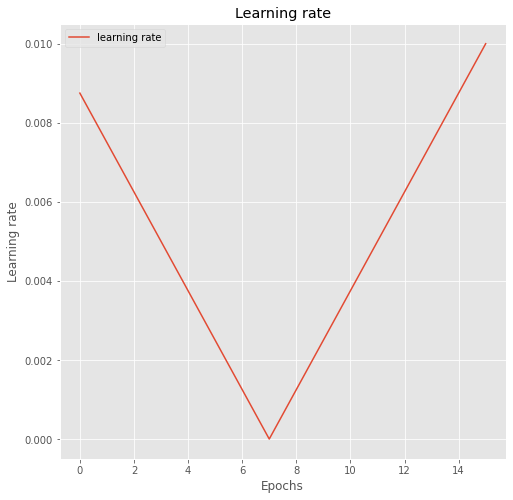

In [61]:
plt.figure(figsize=(8, 8))
plt.title("Learning rate")
plt.plot(results.history["lr"], label="learning rate")
#plt.plot(results.history["val_loss"], label="val_loss")
#plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("Learning rate")
plt.legend();

In [0]:
# load the best model
model.load_weights('model-monuseg-SegNet.h5')

<h1> Testing the model on test Data</h1>

In [63]:
# Evaluate on validation set (this must be equals to the best log_loss)
eval = model.evaluate(X_test, y_test, verbose=1)
print("Test Loss: "+str(eval[0]))
print("Test Accuracy: "+str(eval[1]))
print("Dice co-efficient: "+str(eval[2]))
print("F1-score: "+str(eval[3]))

352/352 [==============================] - 20s 56ms/step
Test Loss: 0.3588969517837871
Test Accuracy: 0.8288334337147799
Dice co-efficient: 0.8644718094305559
F1-score: 0.6526657884771173


<h1> Inference / Predictions</h1>

In [64]:
# Predict on test
preds_test = model.predict(X_test, verbose=1)

352/352 [==============================] - 19s 55ms/step


In [0]:
# Threshold predictions
preds_test_t = (preds_test > 0.5).astype(np.uint8)

In [0]:
def plot_sample(X, y, preds, binary_preds, ix=None):
    """Function to plot the results"""
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 1], cmap='seismic')
    if has_mask:
        ax[0].contour(y[ix, ..., 1].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('original')

    ax[1].imshow(y[ix, ..., 1].squeeze())
    ax[1].set_title('Masks')

    ax[2].imshow(preds[ix, ..., 1].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix, ..., 1].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('Predicted')
    
    ax[3].imshow(binary_preds[ix, ..., 1].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix, ..., 1].squeeze(), colors='k', levels=[0.5])
    ax[3].set_title('Predicted binary');

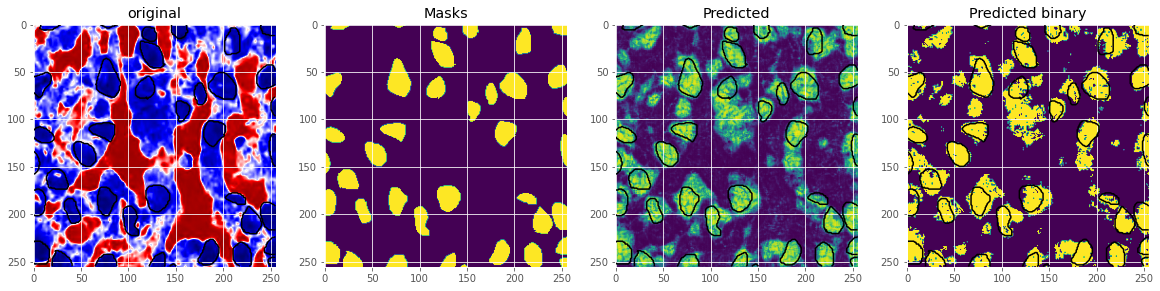

In [67]:
#prediction on test set
# Check if valid data looks all right
plot_sample(X_test, y_test, preds_test, preds_test_t, ix=2)

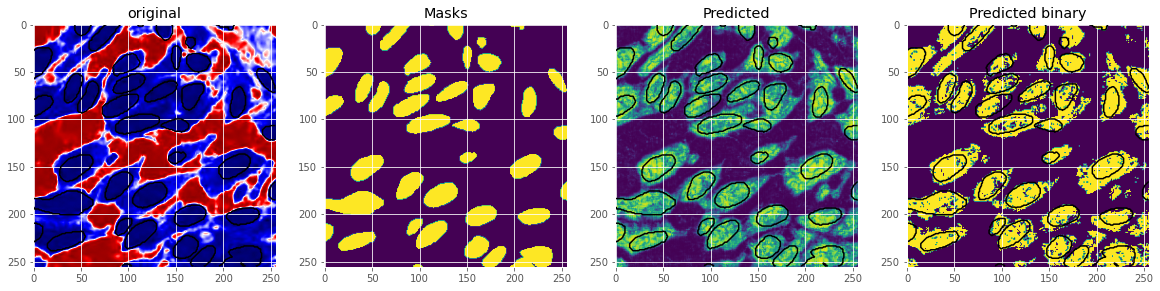

In [68]:
#prediction on test set
# Check if valid data looks all right
plot_sample(X_test, y_test, preds_test, preds_test_t, ix=10)

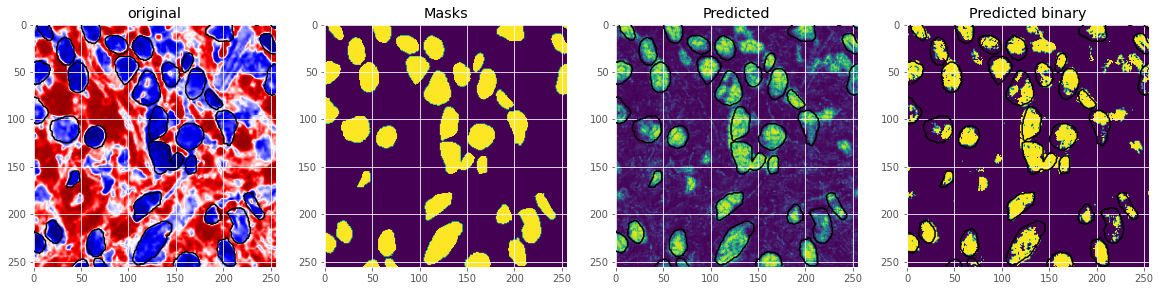

In [69]:
#prediction on test set
# Check if valid data looks all right
plot_sample(X_test, y_test, preds_test, preds_test_t, ix=0)

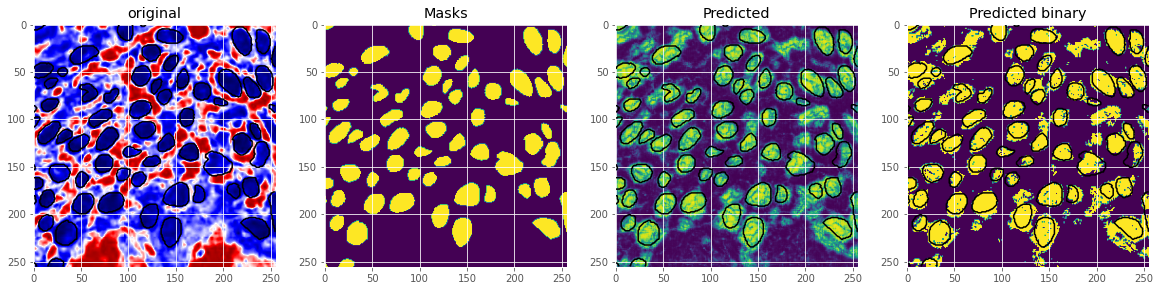

In [70]:
#prediction on test set
# Check if valid data looks all right
plot_sample(X_test, y_test, preds_test, preds_test_t, ix=66)